In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

All audio recordings and associated depression metrics were provided by the [DAIC-WOZ Database](http://dcapswoz.ict.usc.edu/), which was released as part of the 2016 Audio/Visual Emotional Challenge and Workshop [(AVEC 2016)](http://sspnet.eu/avec2016/). The dataset consists of 189 sessions, averaging 16 minutes, between a participant and virtual interviewer called Ellie, controlled by a human interviewer in another room. Prior to the interview, each participant completed a psychiatric questionnaire [(PHQ-8)](http://patienteducation.stanford.edu/research/phq.pdf) from which a binary classification for depression was derived as a truth label for each patient. A transcribed snippet is seen below:

> **Ellie** Who’s someone that’s been a positive influence in your life?

> **Participant** Uh my father.

> **Ellie** Can you tell me about that?

> **Participant** Yeah, he is a uh. He’s a very he’s a man of few words. And uh he's very calm. Slow to anger. And um very warm very loving man. Responsible. And uh he’s a gentleman has a great sense of style and he’s a great cook.

This is the test/train split provided by AVEC 2016. There is an additional validation set consisting of 47 participants, however, since the competition is closed, this dataset cannot be utilized for validation.

Let's examine the test train split:

In [2]:
train = pd.read_csv('training_split.csv')
train.head()

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,303,0,0,0
1,304,0,6,0
2,305,0,7,1
3,310,0,4,1
4,312,0,2,1


In [3]:
test = pd.read_csv('dev_split.csv')
test.head()

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,302,0,4,1
1,307,0,4,0
2,331,0,8,1
3,335,0,12,0
4,346,1,23,0


In [4]:
print('There are {} participants in the training set and {} participants in the test set, resulting \
in roughly a 70/30 train test split.'.format(train.shape[0], test.shape[0], ))

There are 107 participants in the training set and 35 participants in the test set, resulting in roughly a 70/30 train test split.


In [5]:
print('In the train set, {0:.1f}% participants are labelled as depressed.'.format(100 * train['PHQ_Binary'].sum() / train.shape[0]))
print('In the test set, {0:.1f}% participants are labelled as depressed.'.format(100 * test['PHQ_Binary'].sum() / test.shape[0]))

In the train set, 19.6% participants are labelled as depressed.
In the test set, 20.0% participants are labelled as depressed.


In [6]:
print('In the train set, {0:.1f}% participants are male.'.format(100 * train['Gender'].sum() / train.shape[0]))
print('In the test set, {0:.1f}% participants are male.'.format(100 * test['Gender'].sum() / test.shape[0]))

In the train set, 58.9% participants are male.
In the test set, 45.7% participants are male.


Let's put the test set on hold for a second (becuase we shouldn't really be looking at that) and take a look at the distribution of PHQ-8 scores in the train set. Scores range from 0-24. A score of 10 or greater is considered major depression, 20 or more is severe major depression.

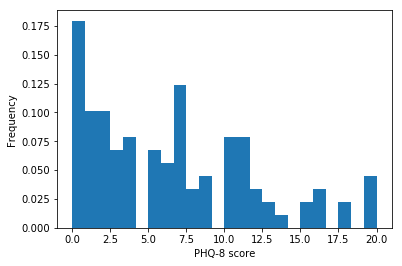

In [37]:
plt.hist(train['PHQ_Score'], bins=24, normed=True);
plt.xlabel('PHQ-8 score')
plt.ylabel('Frequency');

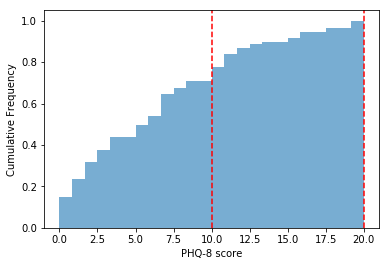

In [42]:
plt.hist(train['PHQ_Score'], bins=24, alpha=0.6, normed=True, cumulative=True);
plt.axvline(10, c='r', ls='--') # threshold for major depression
plt.axvline(20, c='r', ls='--') # threshold for sever major depression
plt.xlabel('PHQ-8 score')
plt.ylabel('Cumulative Frequency');

How many fall into the depression buckets? # CALCULATE

Let's examine a particularly "happy" participant (low PHQ socre) and a severely depressed (high PHQ score), listen to a portion of their interviews and see if us humans can pick out any distiguishing acoustic features.

In [38]:
happy_ppl = train[train['PHQ_Score'] == train['PHQ_Score'].min()]
happy_ppl.sample(1, random_state=15)

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
45,369,0,0,0


In [41]:
sad_ppl = train[train['PHQ_Score'] == train['PHQ_Score'].max()]
sad_ppl.sample(1, random_state=15)

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
40,362,1,20,0


In [5]:
from IPython.display import Audio
Audio('sample_clips/P369_happy_clip.wav')

In [8]:
Audio('sample_clips/P362_depressed_clip.wav')

If I knew one of the individuals was depressed and one was not using comparison, I could classify them from these brief clips. But if you asked me to determine whether either of the speakers was individually dperessed, I would have difficulty determining that threshold. Remember, we're not looking at the words they are saying, but rather how they are saying them (think pauses, inflection, vocal range, etc.). Let's try look at a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of these clips. There's probably a lot of normalization that will have to occur, but we can deal with that later.